<a href="https://colab.research.google.com/github/Ritapaz/projeto/blob/main/Simula%C3%A7%C3%A3o_de_uma_fila_de_caminh%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Contexto do projeto**

Um Centro de Distribuição (CD) recebe caminhões ao longo do dia. Cada caminhão chega, entra em fila e aguarda uma doca de atendimento (recurso). Ao ser atendido, o caminhão ocupa uma doca por um tempo (carregamento/descarga) e depois sai do sistema.

Esse é um sistema clássico de filas com múltiplos servidores (docas), típico para estudar tempo de espera, nível de congestionamento e utilização das docas.

**Objetivos**

**Objetivo geral**

Avaliar o desempenho de um CD com chegadas estocásticas de caminhões e atendimento estocástico nas docas, identificando gargalos e dimensionamento.

**Objetivos específicos**


1. Estimar tempo médio de espera na fila e tempo total no sistema.
2. Medir utilização das docas e tamanho médio/máximo da fila.
1. Calcular níveis de serviço: proporção de caminhões atendidos com espera ≤ SLA.
2. Visualizar o comportamento do sistema ao longo do tempo com gráficos:
* série temporal do tamanho da fila
* histograma do tempo de espera
* ECDF (distribuição acumulada empírica) do tempo de espera
* utilização das docas ao longo do tempo (aprox. por amostragem)

**Modelo e hipóteses**

* Chegadas: processo Poisson ⇒ tempo entre chegadas ~ Exponencial(1/λ)

* Atendimento: tempo de serviço ~ Lognormal (ou triangular/normal truncada)
(lognormal é comum para tempos operacionais com cauda à direita)

* Servidores: c docas idênticas, atendimento FIFO

* Horizonte: simular por T horas

* Warm-up (opcional): descartar período inicial para reduzir viés de partida vazia

**Pseudocódigo**

entrada: taxa_chegada λ, num_docas c, tempo_sim T, SLA, seed



inicializar ambiente


criar recurso docas com capacidade c

listas: espera[], sistema[]

séries: tempo_monitor[], fila_monitor[], ocup_monitor[]

processo GERADOR_CHEGADAS:

    id = 0

    enquanto tempo_atual < T:

        aguardar Exp(1/λ)

        id += 1

        iniciar processo CAMINHAO(id)

processo CAMINHAO(id):

    t_chegada = agora

    requisitar doca (FIFO)

    quando doca alocada:

        t_inicio = agora

        espera = t_inicio - t_chegada

        gerar servico ~ DistribuiçãoServico

        aguardar servico

    liberar doca

    t_saida = agora

    sistema = t_saida - t_chegada

    armazenar espera e sistema

processo MONITOR:

    a cada Δt:

        registrar agora

        registrar tamanho_fila = docas.queue

        registrar ocupacao = docas.count

rodar simulação até T

calcular KPIs: média, percentis, max fila, utilização aproximada, SLA

plotar gráficos (matplotlib)

In [23]:
!pip install simpy


===== RESUMO DO DESEMPENHO (após warm-up, se aplicável) ====
Caminhões analisados: 89
Docas: 4
Taxa de chegada (λ): 8.00 caminhões/hora
Tempo médio de serviço (param.): 30.0 min (dp 15.0 min)

---- Espera na fila (min) ----
Média: 62.32
Mediana (P50): 69.27
P90: 91.22 | P95: 99.81
Máximo: 121.31

---- Tempo total no sistema (min) ----
Média: 91.20

---- Fila e utilização ----
Tamanho médio da fila (amostrado): 9.02
Tamanho máximo da fila (amostrado): 15
Utilização aproximada das docas: 92.15%

---- Nível de serviço ----
P(espera <= 45 min): 23.60%


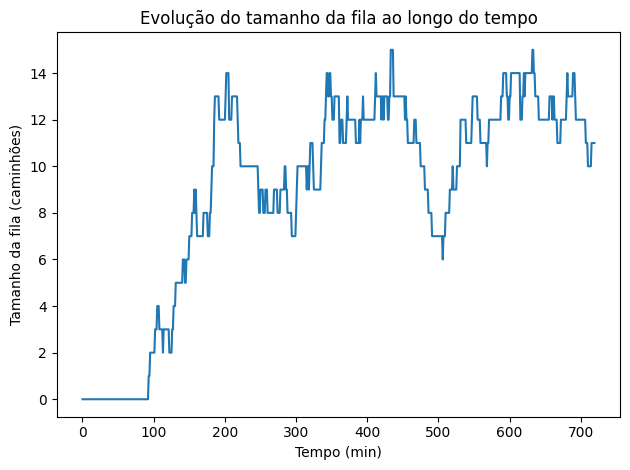

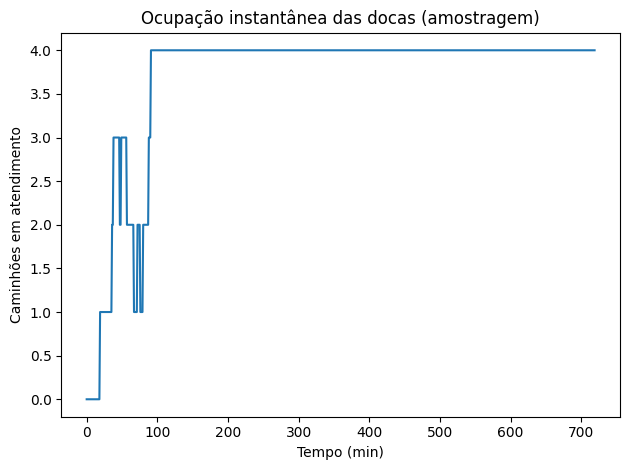

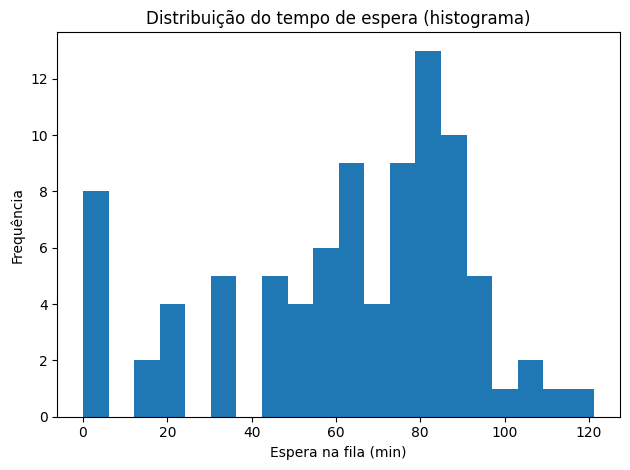

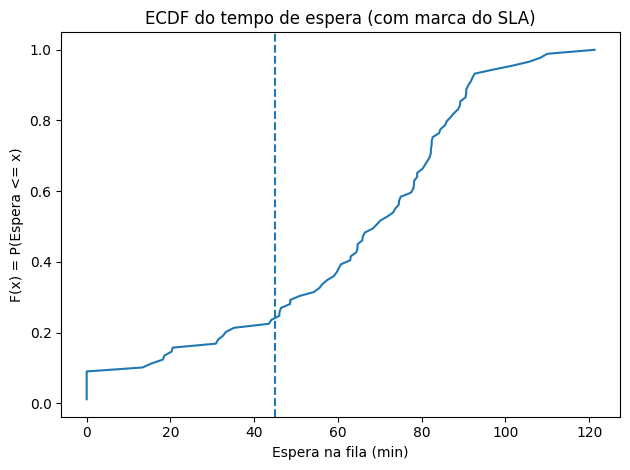

In [25]:
"""
Simulação de eventos discretos:
Fila de caminhões chegando a um Centro de Distribuição (CD) com múltiplas docas.

- Chegadas: Processo de Poisson (interchegadas ~ Exponencial)
- Atendimento: Lognormal (ajuste para tempo operacional)
- Disciplina: FIFO (padrão do SimPy Resource)
- Coleta de métricas e gráficos em matplotlib
"""

import simpy
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
from dataclasses import dataclass


@dataclass
class SimParams:
    arrival_rate_per_hour: float = 8.0  # λ (caminhões/hora)
    num_docks: int = 1                   # c (docas)
    sim_hours: float = 12.0              # horizonte T
    monitor_dt_minutes: float = 1.0      # passo de amostragem do monitor
    sla_minutes: float = 30.0            # SLA: espera máxima desejada
    seed: int = 42                       # reprodutibilidade

    # Parâmetros do tempo de serviço (minutos) como Lognormal:
    # Definimos a média e desvio desejados em minutos e convertemos para mu, sigma da lognormal
    service_mean_minutes: float = 30.0
    service_std_minutes: float = 15.0

    # Warm-up opcional (minutos): descartar registros de caminhões que chegam antes desse tempo
    warmup_minutes: float = 0.0


@dataclass
class SimResults:
    wait_minutes: np.ndarray
    system_minutes: np.ndarray
    arrival_times: np.ndarray
    monitor_time: np.ndarray
    monitor_queue_len: np.ndarray
    monitor_in_service: np.ndarray


def lognormal_mu_sigma_from_mean_std(mean: float, std: float) -> Tuple[float, float]:
    """
    Converte média e desvio padrão (na escala original) para parâmetros (mu, sigma)
    de uma Lognormal, onde:
        X ~ LogNormal(mu, sigma)
        E[X] = exp(mu + sigma^2/2)
        Var[X] = (exp(sigma^2) - 1) * exp(2*mu + sigma^2)
    """
    if mean <= 0 or std <= 0:
        raise ValueError("mean e std devem ser positivos para lognormal.")
    variance = std ** 2
    sigma2 = np.log(1.0 + variance / (mean ** 2))
    sigma = np.sqrt(sigma2)
    mu = np.log(mean) - sigma2 / 2.0
    return float(mu), float(sigma)


def truck_process(
    env: simpy.Environment,
    truck_id: int,
    docks: simpy.Resource,
    rng: np.random.Generator,
    params: SimParams,
    waits: List[float],
    systems: List[float],
    arrivals: List[float],
) -> None:
    """
    Processo de um caminhão:
    - chega
    - entra na fila da doca
    - é atendido (tempo de serviço)
    - sai
    """
    t_arrival = env.now
    arrivals.append(t_arrival)

    with docks.request() as req:
        yield req
        t_start = env.now
        wait = t_start - t_arrival

        # Tempo de serviço lognormal
        mu, sigma = lognormal_mu_sigma_from_mean_std(
            params.service_mean_minutes, params.service_std_minutes
        )
        service_time = float(rng.lognormal(mean=mu, sigma=sigma))

        yield env.timeout(service_time)
        t_depart = env.now

    system_time = t_depart - t_arrival

    # Warm-up: descartar caminhões que chegaram antes do warm-up
    if t_arrival >= params.warmup_minutes:
        waits.append(wait)
        systems.append(system_time)


def arrival_generator(
    env: simpy.Environment,
    docks: simpy.Resource,
    rng: np.random.Generator,
    params: SimParams,
    waits: List[float],
    systems: List[float],
    arrivals: List[float],
) -> None:
    """
    Gera chegadas com interchegada exponencial (Poisson).
    """
    truck_id = 0
    mean_interarrival_minutes = 60.0 / params.arrival_rate_per_hour

    while env.now < params.sim_hours * 60.0:
        interarrival = float(rng.exponential(scale=mean_interarrival_minutes))
        yield env.timeout(interarrival)
        truck_id += 1
        env.process(
            truck_process(env, truck_id, docks, rng, params, waits, systems, arrivals)
        )


def monitor_process(
    env: simpy.Environment,
    docks: simpy.Resource,
    params: SimParams,
    time_points: List[float],
    queue_lengths: List[int],
    in_service: List[int],
) -> None:
    """
    Monitora o sistema por amostragem periódica:
    - tamanho da fila
    - número em serviço (ocupação instantânea)
    """
    dt = params.monitor_dt_minutes
    while env.now < params.sim_hours * 60.0:
        time_points.append(env.now)
        queue_lengths.append(len(docks.queue))
        in_service.append(docks.count)
        yield env.timeout(dt)


def run_simulation(params: SimParams) -> SimResults:
    rng = np.random.default_rng(params.seed)

    env = simpy.Environment()
    docks = simpy.Resource(env, capacity=params.num_docks)

    waits: List[float] = []
    systems: List[float] = []
    arrivals: List[float] = []

    monitor_time: List[float] = []
    monitor_queue_len: List[int] = []
    monitor_in_service: List[int] = []

    env.process(arrival_generator(env, docks, rng, params, waits, systems, arrivals))
    env.process(monitor_process(env, docks, params, monitor_time, monitor_queue_len, monitor_in_service))

    env.run(until=params.sim_hours * 60.0)

    return SimResults(
        wait_minutes=np.array(waits, dtype=float),
        system_minutes=np.array(systems, dtype=float),
        arrival_times=np.array(arrivals, dtype=float),
        monitor_time=np.array(monitor_time, dtype=float),
        monitor_queue_len=np.array(monitor_queue_len, dtype=int),
        monitor_in_service=np.array(monitor_in_service, dtype=int),
    )


def ecdf(values: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    x = np.sort(values)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y


def summarize_and_plot(params: SimParams, results: SimResults) -> None:
    waits = results.wait_minutes
    systems = results.system_minutes

    if len(waits) == 0:
        raise RuntimeError("Nenhum caminhão foi registrado (verifique warm-up e horizonte).")

    sla = params.sla_minutes
    service_level = float(np.mean(waits <= sla))

    wait_mean = float(np.mean(waits))
    wait_p50 = float(np.percentile(waits, 50))
    wait_p90 = float(np.percentile(waits, 90))
    wait_p95 = float(np.percentile(waits, 95))
    wait_max = float(np.max(waits))

    system_mean = float(np.mean(systems))

    avg_queue = float(np.mean(results.monitor_queue_len))
    max_queue = int(np.max(results.monitor_queue_len))

    # Utilização aproximada por amostragem: E[count]/capacity
    utilization = float(np.mean(results.monitor_in_service) / params.num_docks)

    print("===== RESUMO DO DESEMPENHO (após warm-up, se aplicável) ====")
    print(f"Caminhões analisados: {len(waits)}")
    print(f"Docas: {params.num_docks}")
    print(f"Taxa de chegada (λ): {params.arrival_rate_per_hour:.2f} caminhões/hora")
    print(f"Tempo médio de serviço (param.): {params.service_mean_minutes:.1f} min (dp {params.service_std_minutes:.1f} min)")
    print("")
    print("---- Espera na fila (min) ----")
    print(f"Média: {wait_mean:.2f}")
    print(f"Mediana (P50): {wait_p50:.2f}")
    print(f"P90: {wait_p90:.2f} | P95: {wait_p95:.2f}")
    print(f"Máximo: {wait_max:.2f}")
    print("")
    print("---- Tempo total no sistema (min) ----")
    print(f"Média: {system_mean:.2f}")
    print("")
    print("---- Fila e utilização ----")
    print(f"Tamanho médio da fila (amostrado): {avg_queue:.2f}")
    print(f"Tamanho máximo da fila (amostrado): {max_queue}")
    print(f"Utilização aproximada das docas: {utilization:.2%}")
    print("")
    print("---- Nível de serviço ----")
    print(f"P(espera <= {sla:.0f} min): {service_level:.2%}")

    # ============ GRÁFICOS (matplotlib, sem cores definidas) ============

    # 1) Série temporal do tamanho da fila
    plt.figure()
    plt.plot(results.monitor_time, results.monitor_queue_len)
    plt.xlabel("Tempo (min)")
    plt.ylabel("Tamanho da fila (caminhões)")
    plt.title("Evolução do tamanho da fila ao longo do tempo")
    plt.tight_layout()

    # 2) Série temporal do número em serviço (ocupação instantânea)
    plt.figure()
    plt.plot(results.monitor_time, results.monitor_in_service)
    plt.xlabel("Tempo (min)")
    plt.ylabel("Caminhões em atendimento")
    plt.title("Ocupação instantânea das docas (amostragem)")
    plt.tight_layout()

    # 3) Histograma do tempo de espera
    plt.figure()
    plt.hist(waits, bins=20)
    plt.xlabel("Espera na fila (min)")
    plt.ylabel("Frequência")
    plt.title("Distribuição do tempo de espera (histograma)")
    plt.tight_layout()

    # 4) ECDF do tempo de espera (bom para SLA)
    x, y = ecdf(waits)
    plt.figure()
    plt.plot(x, y)
    plt.axvline(params.sla_minutes, linestyle="--")
    plt.xlabel("Espera na fila (min)")
    plt.ylabel("F(x) = P(Espera <= x)")
    plt.title("ECDF do tempo de espera (com marca do SLA)")
    plt.tight_layout()

    plt.show()


def main() -> None:
    params = SimParams(
        arrival_rate_per_hour=8.0, # Alterado para 12.0
        num_docks=4,                # Alterado para 3
        sim_hours=12.0,
        monitor_dt_minutes=1.0,
        sla_minutes=45.0,           # Alterado para 45.0
        seed=42,
        service_mean_minutes=30.0,
        service_std_minutes=15.0,
        warmup_minutes=10.0,
    )

    results = run_simulation(params)
    summarize_and_plot(params, results)


if __name__ == "__main__":
    main()